In [0]:
import os
os.chdir('./drive/My Drive/Challenge-Owkin/')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read files

In [0]:
from sklearn import preprocessing

def normalizing_input(x_train, x_test):
    all_x = pd.concat([x_train, x_test])
    x_val = all_x.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x_val)
    df = pd.DataFrame(x_scaled, index=all_x.index, columns=all_x.columns)
    return df.loc[x_train.index], df.loc[x_test.index]

def cleaning_clinical(clinical):
    """
    Cleaning the clinical dataframe.
    :param clinical:
    :return:
    """
    # Encoding label for SourceDataset
    le = preprocessing.LabelEncoder()
    le.fit(clinical['SourceDataset'])
    le.transform(clinical['SourceDataset'])
    clinical['SourceDataset'] = le.transform(clinical['SourceDataset'])
    # Cleaning Histology
    clinical.replace("NSCLC NOS (not otherwise specified)", "nos", inplace=True)
    clinical.replace("Adenocarcinoma", "adenocarcinoma", inplace=True)
    clinical.replace("Squamous cell carcinoma", "squamous cell carcinoma", inplace=True)
    # Dummies for Histology
    clinical = pd.get_dummies(clinical)
    # Fill age nan
    clinical['age'].fillna((clinical['age'].mean()), inplace=True)

    return clinical

def clean_clinical_data(file, newfile):
    """
    Cleaning clinical data.
    :param file: clinical data file
    :param newfile: path for the cleaned data file.
    :return:
    """
    clinical = pd.read_csv(file, index_col=0)
    cleaned = cleaning_clinical(clinical)
    cleaned.to_csv(newfile)

def y_dataframe_to_rsf_input(y_df):
    """
    Input for random survival forest.
    :param y_df: event + survival time dataframe.
    :return:
    """
    y_array = []
    Y = y_df.to_numpy()
    for y in Y:
        tuple = (bool(y[1]), y[0])
        y_array.append(tuple)
    return np.array(y_array, dtype = [(f'{y_df.columns[1]}', np.bool), (f'{y_df.columns[0]}', np.float)])

In [0]:
def read_input(file_radiomics, file_clinical):
    """
    Read radiomics and clinical feature and return dataframe.
    :param file_radiomics: filename
    :param file_clinical: filename
    :return:
    """
    radiomics = pd.read_csv(file_radiomics, index_col=0)
    clinical = pd.read_csv(file_clinical, index_col=0)
    clinical = cleaning_clinical(clinical)
    input = pd.concat([radiomics, clinical], axis=1)
    return input

def read_output(file_output):
    """
    Return dataframe for event + survival time.
    :param file_output:
    :return:
    """
    output = pd.read_csv(file_output, index_col=0, header=0)
    return output

def load_owkin_data(radiomics_path_train="data/train/features/radiomics.csv",
                    clinical_path_train="data/train/features/clinical_data.csv",
                    label_path_train='data/train/y_train.csv',
                    radiomics_path_test="data/test/features/radiomics.csv",
                    clinical_path_test="data/test/features/clinical_data.csv"):
    """
    Load Owkin data: return PyRadiomics + clinical features of training set in dataframe,
                    event + time of training set in dataframe, and
                    PyRadiomics + clinical features of testing set in dataframe,
    """
    input_train = read_input(radiomics_path_train, clinical_path_train)
    output_train = read_output(label_path_train)
    input_test = read_input(radiomics_path_test, clinical_path_test)
    return input_train, output_train, input_test

if __name__ == '__main__':
    input_train, output_train, input_test = load_owkin_data()

# Data exploration

In [0]:
x_train, y_train, x_test = load_owkin_data()
x_train, x_test = normalizing_input(x_train, x_test)

Text(0.5, 1.0, 'Histogram distribution according to event')

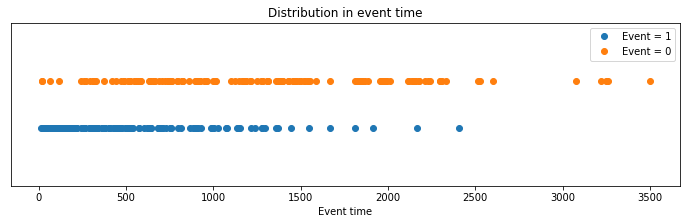

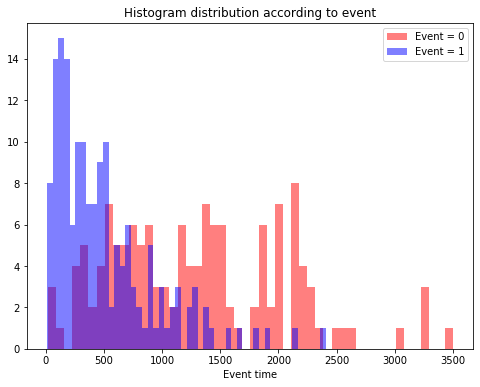

In [0]:
""" Distribution of patient in event time """
dead = y_train.loc[y_train['Event'] == 1]['SurvivalTime']
alive = y_train.loc[y_train['Event'] == 0]['SurvivalTime']

plt.figure(figsize=(12, 3))
plt.plot(dead, np.zeros(len(dead)), 'o', label='Event = 1')
plt.plot(alive, np.zeros(len(alive)) + 0.4, 'o', label='Event = 0')
plt.ylim([-0.5, 0.9])
plt.xlabel('Event time')
plt.yticks([])
plt.legend()
plt.title('Distribution in event time')

plt.figure(figsize=(8,6))
n_bins = 50
plt.hist(alive, bins = n_bins, fc=(1, 0, 0, 0.5), label = 'Event = 0')
plt.hist(dead, bins = n_bins, fc=(0, 0, 1, 0.5), label = 'Event = 1')
plt.legend()
plt.xlabel('Event time')
plt.title('Histogram distribution according to event')


**Hypothesis**: Patients with event 1 (people who died in the experience) with an event time less than 300 are considered as low survival probability patients. Patients with event 0 (people who are still alive in the experience) with an event time higher than 2000 are considered as high survival probability patients.

In [0]:
""" Low survival probability patients """
dead_df = y_train.loc[y_train['Event'] == 1] 
low_survival_index = dead_df.loc[dead_df['SurvivalTime'] <= 300].index
low_surv_df = x_train.loc[low_survival_index]
print(f'Number of low survival probability patients: {len(low_survival_index)}')
print(low_survival_index)

""" High survival probability patients """
alive_df = y_train.loc[y_train['Event'] == 0]
high_survival_index = alive_df.loc[alive_df['SurvivalTime'] >= 2000].index
high_surv_df = x_train.loc[high_survival_index]
print(f'Number of high survival probability patients: {len(high_survival_index)}')
print(high_survival_index)

Number of low survival probability patients: 66
Int64Index([384, 100, 173,  83, 149, 316, 340, 359, 210, 250, 262, 147, 224,
            272, 418, 116,  30,  29, 266, 175, 303, 367, 208,  17, 237, 355,
            294, 107, 397,  67,  24, 138, 124, 145, 126, 282, 382,  76, 196,
            309, 385,  43, 269,  21,  98, 183, 383,  26, 347,  14, 400, 328,
             15, 358, 159,  93, 255, 395, 346, 112, 345, 299, 373, 213,  56,
            365],
           dtype='int64', name='PatientID')
Number of high survival probability patients: 25
Int64Index([284, 143,  94, 380,  48, 334, 257, 403, 130, 275, 406, 305,  25,
            184, 256, 148, 297, 393,  36, 391,  11, 279, 362,  69,  58],
           dtype='int64', name='PatientID')


In [0]:
""" Print features of the population having a small range Q3 - Q1 """
def small_range_Q3_Q1(df, threshold, title):
    descip = df.describe()
    range_df = descip.loc['75%'] - descip.loc['25%']

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    axs[0].hist(range_df, 100)
    axs[0].set_xlabel('Value of the range Q3 - Q1')
    axs[0].set_title('Histogram of all the features according to their Q3 - Q1 range')
    small_range_id = range_df.loc[range_df < threshold]

    low_range_features = small_range_id.axes[0]
    df[low_range_features].boxplot(ax=axs[1], figsize=(8,6), rot=90)
    axs[1].set_title(f'Boxplot of the pop for only features with Q3 - Q1 < {threshold}')

    fig.suptitle(title)

    return small_range_id.axes[0]

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,Mstage,Nstage,SourceDataset,Tstage,age,Histology_adenocarcinoma,Histology_large cell,Histology_nos,Histology_squamous cell carcinoma
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,0.487467,0.347023,0.335794,0.258995,0.539531,0.225398,0.262026,0.150492,0.062212,0.468395,0.130353,0.180245,0.796521,0.318760,0.881046,0.320120,0.242714,0.250263,0.588859,0.382911,0.330195,0.224176,0.610797,0.113941,0.386646,0.201651,0.075018,0.783907,0.366114,0.167475,0.189866,0.398171,0.617865,0.603743,0.475145,0.785028,0.886524,0.777430,0.621230,0.268710,0.692704,0.457673,0.555241,0.166364,0.128119,0.117365,0.493929,0.043276,0.576092,0.049672,0.503588,0.043750,0.224784,0.030303,0.363636,0.106061,0.344697,0.542331,0.212121,0.257576,0.166667,0.318182
std,0.178726,0.173704,0.204154,0.151996,0.176824,0.196718,0.221060,0.174946,0.089625,0.234824,0.186868,0.134698,0.155907,0.242983,0.135888,0.159389,0.129628,0.178189,0.179367,0.224936,0.213190,0.213855,0.218800,0.158847,0.110614,0.201259,0.102829,0.127932,0.201452,0.149070,0.160782,0.221967,0.228886,0.236837,0.149150,0.127681,0.147873,0.184570,0.194795,0.170773,0.195691,0.232390,0.225852,0.156598,0.182698,0.123460,0.244297,0.129108,0.214483,0.129918,0.174382,0.139397,0.169813,0.172733,0.298012,0.310275,0.247158,0.205652,0.411943,0.440650,0.375534,0.469340
min,0.077842,0.031678,0.023903,0.057762,0.101398,0.003058,0.026136,0.000474,0.000357,0.071819,0.003393,0.041733,0.279380,0.016698,0.108265,0.174419,0.028302,0.034499,0.000000,0.042157,0.020204,0.007781,0.131618,0.003087,0.094170,0.006610,0.000359,0.444414,0.000000,0.000000,0.003687,0.016297,0.110119,0.071118,0.000000,0.212421,0.231088,0.249223,0.139221,0.004558,0.053378,0.000000,0.000000,0.002852,0.000213,0.000952,0.000000,0.000492,0.132005,0.000420,0.106711,0.004230,0.011810,0.000000,0.000000,0.000000,0.000000,0.0

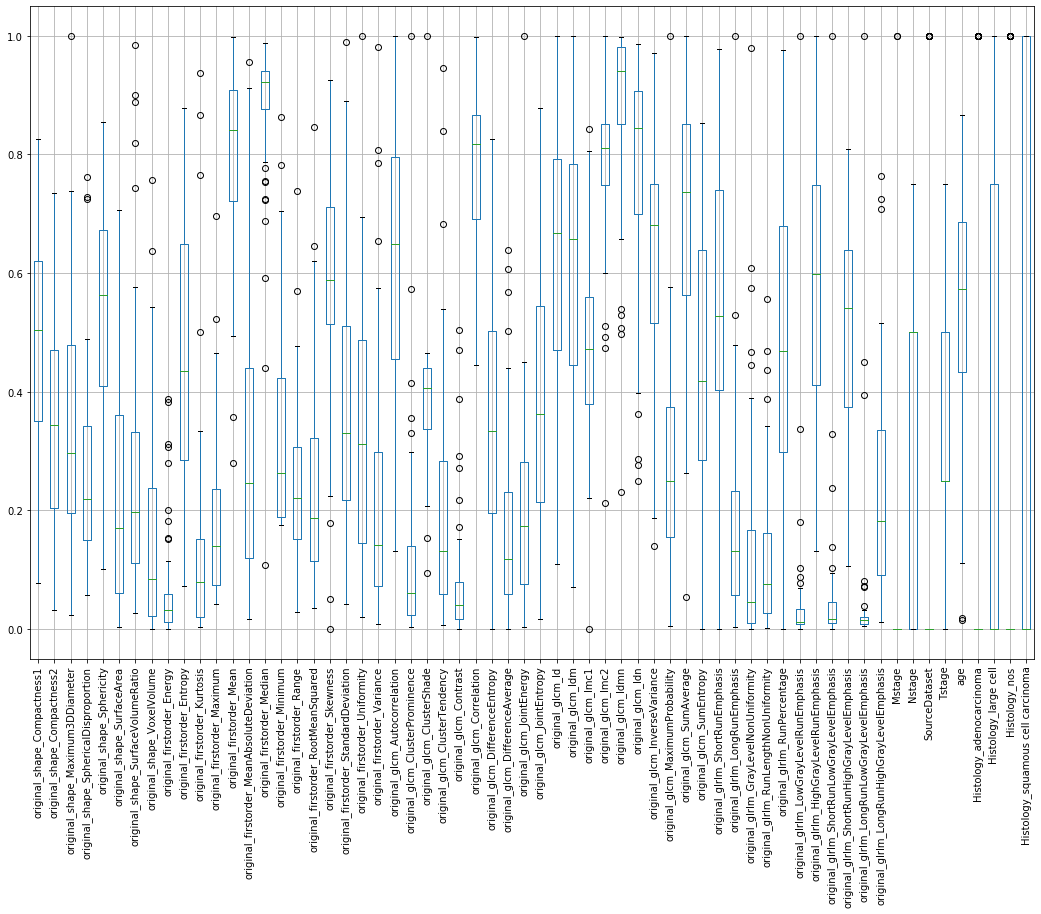

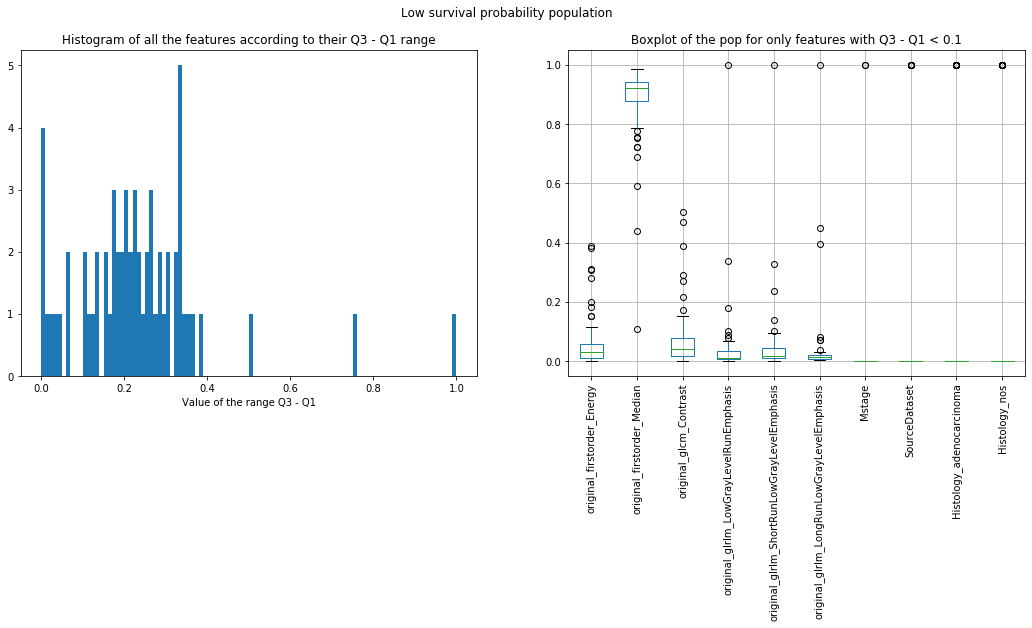

In [0]:
""" Statistics of the low survival probability population """
threshold = 0.1
low_surv_df.boxplot(figsize=(18,12), rot=90)
low_range_features_low_surv = small_range_Q3_Q1(low_surv_df, threshold, 'Low survival probability population')
low_surv_df.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_StandardDeviation,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,Mstage,Nstage,SourceDataset,Tstage,age,Histology_adenocarcinoma,Histology_large cell,Histology_nos,Histology_squamous cell carcinoma
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.0,25.000000,25.00,25.000000,25.000000,25.000000,25.0,25.0,25.000000
mean,0.528699,0.386053,0.155596,0.227251,0.580191,0.073387,0.472101,0.039533,0.034618,0.734970,0.024867,0.109627,0.554875,0.495485,0.650454,0.320207,0.179325,0.474403,0.736546,0.525071,0.107190,0.336683,0.393118,0.099645,0.409509,0.284323,0.220431,0.567119,0.659199,0.408316,0.042805,0.700291,0.259666,0.234801,0.710847,0.702529,0.642363,0.464326,0.349054,0.083082,0.488122,0.714498,0.861373,0.026976,0.033689,0.055575,0.843027,0.064009,0.366474,0.084139,0.388971,0.027857,0.055315,0.0,0.060000,0.96,0.180000,0.492954,0.840000,0.0,0.0,0.160000
std,0.168850,0.166702,0.127233,0.146776,0.167243,0.128119,0.198965,0.112869,0.056018,0.186326,0.033660,0.083138,0.238076,0.190812,0.263802,0.144562,0.093458,0.222941,0.107936,0.171027,0.137891,0.181667,0.235517,0.078453,0.070431,0.156726,0.152921,0.183115,0.164902,0.180587,0.071091,0.197514,0.183816,0.187780,0.106989,0.143232,0.175442,0.188608,0.239835,0.103035,0.223932,0.201401,0.128670,0.035352,0.113364,0.151448,0.145172,0.060426,0.228619,0.075112,0.230428,0.031181,0.053474,0.0,0.165831,0.20,0.244949,0.185810,0.374166,0.0,0.0,0.374166
min,0.121875,0.053049,0.019842,0.029617,0.155439,0.003902,0.053241,0.000987,0.000609,0.177803,0.003280,0.032813,0.060449,0.097520,0.132712,0.174419,0.075472,0.080177,0.475822,0.158818,0.009864,0.045088,0.072969,0.008526,0.277496,0.031031,0.022961,0.226483,0.233236,0.074541,0.001337,0.158990,0.021111,0.000551,0.468394,0.405984,0.384392,0.188914,0.014852,0.001273,0.130378,0.135793,0.454677,0.000000,0.000339,0.001270,0.388663,0.002905,0.087059,0.004656,0.102891,0.001823,0.006737,0.0,0.000000,0.00,0.000000,0.070881,0.000000,0.0,0.0,0.000000
25%,0.445939,0.287041,0.077003,0.1

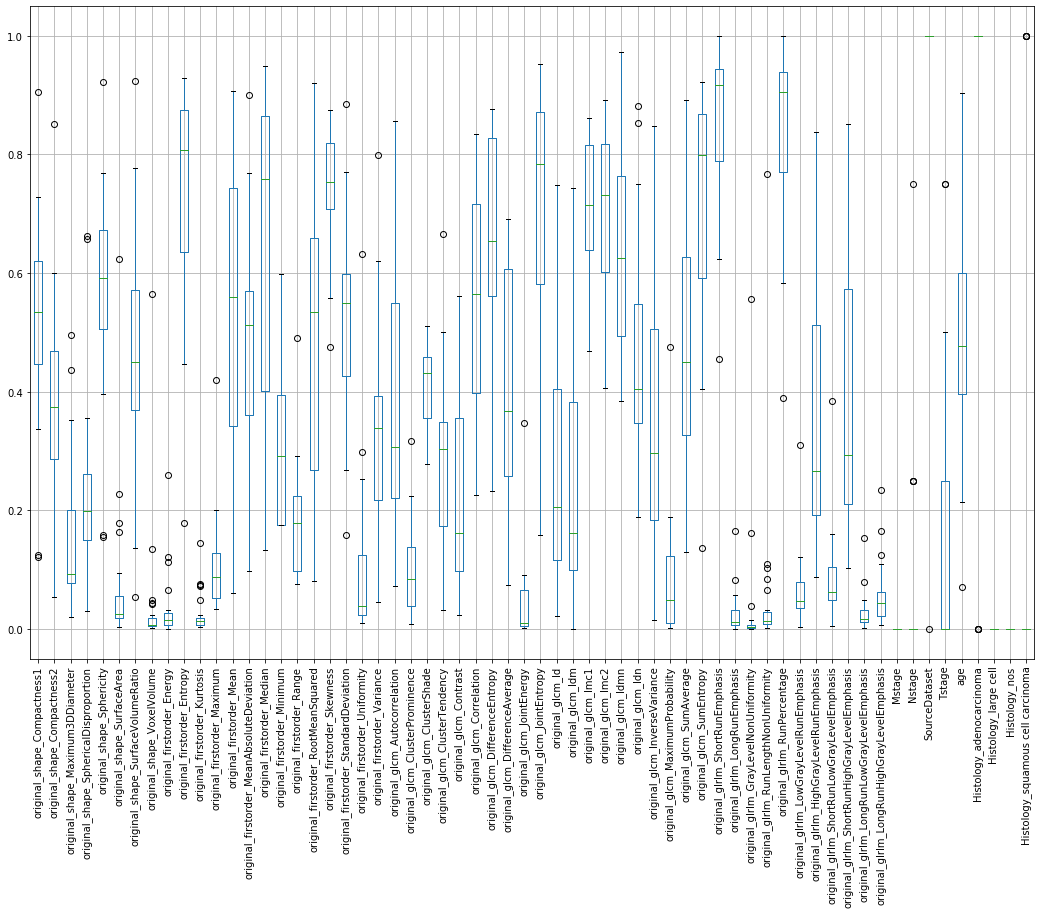

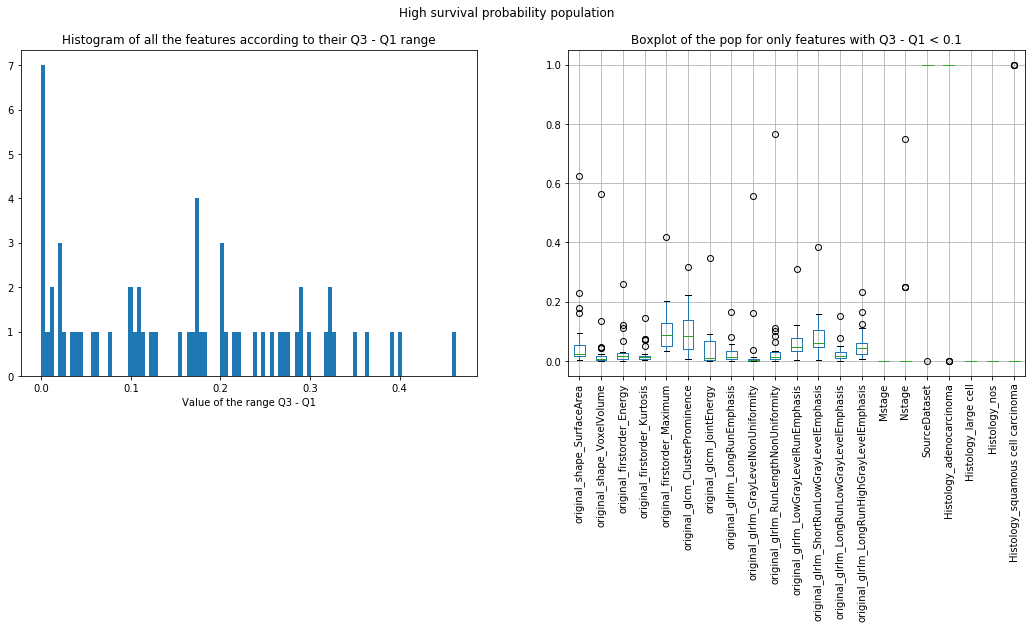

In [0]:
""" Statistics of the high survival probability population """
high_surv_df.boxplot(figsize=(18,12), rot=90)
low_range_features_high_surv = small_range_Q3_Q1(high_surv_df, threshold, 'High survival probability population')
high_surv_df.describe()

In [0]:
""" Intersection of low quantile range features extracted from both population """
# print(low_range_features_low_surv)
# print(low_range_features_high_surv)
intersection_features = list(set(low_range_features_low_surv) & set(low_range_features_high_surv))
union_features = list(low_range_features_low_surv) + list(set(low_range_features_high_surv) - set(low_range_features_low_surv))
print('Features with low range in both population', intersection_features)
print('Features with low range in one of the population', union_features)

Features with low range in both population ['original_glrlm_LongRunLowGrayLevelEmphasis', 'Histology_nos', 'SourceDataset', 'original_firstorder_Energy', 'Mstage', 'Histology_adenocarcinoma', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glrlm_LowGrayLevelRunEmphasis']
Features with low range in one of the population ['original_firstorder_Energy', 'original_firstorder_Median', 'original_glcm_Contrast', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'Mstage', 'SourceDataset', 'Histology_adenocarcinoma', 'Histology_nos', 'Nstage', 'original_glrlm_RunLengthNonUniformity', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_LongRunEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_firstorder_Kurtosis', 'original_shape_VoxelVolume', 'original_shape_SurfaceArea', 'Histology_large cell', 'original_firstorder_Maximum', 'original_glcm_JointEnergy', 'original_glcm_ClusterPromi

In [0]:
""" Comparing the mean value of the features in both populations """
feat_ = union_features
s1 = low_surv_df[feat_].describe().loc['mean']
s2 = low_surv_df[feat_].describe().loc['std']
s3 = low_surv_df[feat_].describe().loc['75%'] - low_surv_df[feat_].describe().loc['25%']
s4 = high_surv_df[feat_].describe().loc['mean']
s5 = high_surv_df[feat_].describe().loc['std']
s6 = high_surv_df[feat_].describe().loc['75%'] - high_surv_df[feat_].describe().loc['25%']

df = pd.concat([s1, s2, s3, s4, s5, s6], axis=1)
df.columns = ['low_surv_df_mean', 'low_surv_std', 'low_surve_Q3Q1_range', 'high_surv_df_mean', 'high_surv_std', 'high_surv_Q3Q1_range']
df

,low_surv_df_mean,low_surv_std,low_surve_Q3Q1_range,high_surv_df_mean,high_surv_std,high_surv_Q3Q1_range
original_firstorder_Energy,0.062212,0.089625,0.046987,0.034618,0.056018,0.020110
original_firstorder_Median,0.881046,0.135888,0.064901,0.650454,0.263802,0.463329
original_glcm_Contrast,0.075018,0.102829,0.062408,0.220431,0.152921,0.257434
original_glrlm_LowGrayLevelRunEmphasis,0.043276,0.129108,0.026656,0.064009,0.060426,0.044255
original_glrlm_ShortRunLowGrayLevelEmphasis,0.049672,0.129918,0.034814,0.084139,0.075112,0.056073
original_glrlm_LongRunLowGrayLevelEmphasis,0.043750,0.139397,0.011601,0.027857,0.031181,0.021123
Mstage,0.030303,0.172733,0.000000,0.000000,0.000000,0.000000
SourceDataset,0.106061,0.310275,0.000000,0.960000,0.200000,0.000000
Histology_adenocarcinoma,0.212121,0.411943,0.000000,0.840000,0.374166,0.000000
Histology_nos,0.166667,0.375534,0.000000,0.000000,0.000000,0.000000


**Conclusion**: The discriminating feature are `SourceDataset`, `Histology_adenocarcinoma`. 

# Variable selection

 ## LASSO

 See https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html#cox.
 Features are extracted in using the notebook ``lasso/FeatureSelectionLasso.ipynb``.

In [0]:
input_train, output_train, input_test = load_owkin_data()
std_input_train, std_input_test = normalizing_input(input_train, input_test)
std_input_train.to_csv('MergedStdTrainingInput.csv')

In [0]:
# Variables 

lasso_features_lamb_lse = ['original_shape_Maximum3DDiameter',
            'original_shape_VoxelVolume',
            'original_firstorder_Maximum',
            'original_firstorder_Mean',
            'original_glcm_ClusterProminence',
            'original_glrlm_GrayLevelNonUniformity',
            'original_glrlm_RunPercentage',
            'Mstage',
            'Nstage',
            'SourceDataset',
            'age',
            'Histology_nos']

lasso_features_lamb_min = ['original_shape_Maximum3DDiameter',
        'original_shape_VoxelVolume',
        'original_firstorder_Maximum',
        'original_firstorder_Mean',
        'original_glcm_ClusterProminence',
        'original_glrlm_GrayLevelNonUniformity',
        'original_glrlm_RunPercentage',
        'Mstage',
        'Nstage',
        'SourceDataset',
        'age',
        'Histology_nos']

lasso_features_fabrice = ['Mstage',
            'Nstage',
            'SourceDataset',
            'age',
            'original_shape_VoxelVolume',
            'original_firstorder_Maximum',
            'original_firstorder_Mean',
            'original_glcm_ClusterProminence',
            'original_glcm_Idm',
            'original_glcm_Idn',
            'original_glrlm_RunPercentage']       

In [0]:
input = "original_shape_Maximum3DDiameter''original_shape_VoxelVolume''original_firstorder_Maximum''original_firstorder_Mean''original_glcm_ClusterProminence''original_glrlm_GrayLevelNonUniformity''original_glrlm_RunPercentage''Mstage''Nstage''SourceDataset''age''Histology_nos"
features = input.split('\'\'')
features

['original_shape_Maximum3DDiameter',
 'original_shape_VoxelVolume',
 'original_firstorder_Maximum',
 'original_firstorder_Mean',
 'original_glcm_ClusterProminence',
 'original_glrlm_GrayLevelNonUniformity',
 'original_glrlm_RunPercentage',
 'Mstage',
 'Nstage',
 'SourceDataset',
 'age',
 'Histology_nos']

## Cross correlation

# Random surivival forest

In [0]:
!pip install scikit-survival
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import cross_validate

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 368 from PyObject
  return f(*args, **kwds)


In [0]:
def load_data(features=None):
    """ Load data for RSF usage """
    X_df, y_df, _ = load_owkin_data()
    if features != None:
        X_df = X_df[features]
    X = X_df.to_numpy()
    y = y_dataframe_to_rsf_input(y_df)
    return X_df, y_df, X, y

X_df, y_df, X, y = load_data(lasso_features_bis)
feature_name = list(X_df.columns.values)

"""
Train model
"""
params = {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
rsf = RandomSurvivalForest(n_estimators = params['n_estimators'],
                           min_samples_split = params['min_samples_split'],
                           min_samples_leaf = params['min_samples_leaf'],
                           max_features="sqrt",
                           n_jobs=-1
                           )
cross_validate(rsf, X, y, cv=5)

{'fit_time': array([0.11209631, 0.1188364 , 0.11608171, 0.11968184, 0.12150097]),
 'score_time': array([0.10321617, 0.10320401, 0.10330343, 0.10309672, 0.1030724 ]),
 'test_score': array([0.68773234, 0.62244124, 0.57537155, 0.70496324, 0.65698219])}

# CoxPH

In [0]:
# Prediction
def predict(model, X, threshold=0.9):
    prediction = model.predict_survival_function(X)
    y_pred = []
    for pred in prediction:
        time = pred.x
        survival_prob = pred.y
        i_pred = 0
        while i_pred < len(survival_prob) - 1 and survival_prob[i_pred] > threshold:
            i_pred += 1
        y_pred.append(time[i_pred])
    return pd.DataFrame(np.array([[y, np.nan] for y in y_pred]), index=X.index, columns=['SurvivalTime', 'Event'])

## Baseline

In [0]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sksurv.util import Surv

In [0]:
""" Select features """
features = lasso_features_lamb_lse

# Read data
input_train, output_train, input_test = load_owkin_data()
input_train = input_train[features]
input_test = input_test[features]
input_train, input_test = normalizing_input(input_train, input_test)
structured_y = Surv.from_dataframe('Event', 'SurvivalTime', output_train)

# Grid search
tuned_params = {"alpha": np.linspace(0.5, 4, 1000)
                }
grid_search = RandomizedSearchCV(CoxPHSurvivalAnalysis(), tuned_params, cv=5, n_jobs=-1, n_iter=500)
grid_search.fit(input_train, structured_y)
print(grid_search.best_score_)
best_params = grid_search.best_params_
print(best_params)

0.6977574356007257
{'alpha': 1.7052052052052051}


## Coxnet

In [0]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sksurv.util import Surv

In [0]:
""" Select features """
features = lasso_features_lamb_lse

# Read data
input_train, output_train, input_test = load_owkin_data()
input_train = input_train[features]
input_test = input_test[features]
input_train, input_test = normalizing_input(input_train, input_test)
structured_y = Surv.from_dataframe('Event', 'SurvivalTime', output_train)

# Grid search
tuned_params = {"l1_ratio": np.linspace(0.0027, 0.0028, 1000),
                "n_alphas": range(65, 75, 1),
                }
grid_search = RandomizedSearchCV(CoxnetSurvivalAnalysis(), tuned_params, cv=5, n_jobs=-1, n_iter=500)
grid_search.fit(input_train, structured_y)
print(grid_search.best_score_)
best_params = grid_search.best_params_
print(best_params)

0.7019381798497382
{'n_alphas': 68, 'l1_ratio': 0.0027616616616616615}


In [0]:
# Prediction
def predict(model, X, threshold=0.9):
    prediction = model.predict_survival_function(X)
    y_pred = []
    for pred in prediction:
        time = pred.x
        survival_prob = pred.y
        i_pred = 0
        while i_pred < len(survival_prob) - 1 and survival_prob[i_pred] > threshold:
            i_pred += 1
        y_pred.append(time[i_pred])
    return pd.DataFrame(np.array([[y, np.nan] for y in y_pred]), index=X.index, columns=['SurvivalTime', 'Event'])

coxph = CoxnetSurvivalAnalysis(**best_params, fit_baseline_model=True)
coxph.fit(input_train, structured_y)
y_pred = predict(coxph, input_test)
y_pred.to_csv('submission.csv')